In [117]:
import pandas as pd
import numpy as np

In [118]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [119]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

In [120]:

#brain_vars_df = pd.read_csv('session4_oasis2_atropy_20240418_after.csv')
brain_vars_df = pd.read_csv('MPR3_oasis2_atropy_20240416_after.csv')
phenotype_df = pd.read_csv('oasis_longitudinal_oasis2.csv')



In [121]:

#brain_vars_df['subject_clean'] = brain_vars_df['subject'].str.extract(r'(OAS2_\d+_MR\d)')
#brain_vars_df

In [122]:
phenotype_df

,Subject ID,MRI ID,Demention,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,0.0,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,0.0,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,1.0,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,1.0,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,1.0,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,1.0,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,1.0,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,0.0,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,0.0,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


In [123]:
phenotype_df['MRI ID'] = phenotype_df['MRI ID'].str.strip()
phenotype_df = phenotype_df.dropna(subset=['Demention'])  # Drop rows where target value is NaN
phenotype_df['Demention'] = phenotype_df['Demention'].astype(int)


#brain_vars_df['subject_clean'] = brain_vars_df['subject'].str.extract(r'(OAS2_\d+)')

#brain_vars_df['subject_clean'] = brain_vars_df['subject'].str.extract(r'(OAS2_\d+_MR\d)')
brain_vars_df['subject_clean'] = brain_vars_df['subject'].str.extract(r'(OAS2_\d+_MR1)')

merged_data = pd.merge(brain_vars_df, phenotype_df, left_on='subject_clean', right_on='MRI ID')
# 뇌만 가지고 해야하니까 , 다른거 다 빼고할것!!! 
non_feature_columns = ['subject', 'subject_clean', 'Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'Hand','Demention', 'Age','EDUC',
 'SES',
 'MMSE',
 'CDR',
 'eTIV',
 'nWBV',
 'ASF', 'unknwon','HippocampusOccupancyScore','HippocampusAsymmetryIndex']
numeric_brain_var_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_brain_var_columns = [col for col in numeric_brain_var_columns if col not in non_feature_columns]


scaler = StandardScaler()
merged_data[numeric_brain_var_columns] = scaler.fit_transform(merged_data[numeric_brain_var_columns])

/tmp/ipykernel_2908533/2241993532.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_df['Demention'] = phenotype_df['Demention'].astype(int)


In [124]:
X = merged_data[numeric_brain_var_columns]
y = merged_data['Demention']

In [125]:
X.columns

Index(['Unnamed: 0', 'whole_brain', 'cortical_gm', 'combined_cerebral_wm',
       'frontal', 'temporal', 'parietal', 'occipital', 'insula', 'thalamus',
       'caudate', 'putamen', 'pallidum', 'hippocampus', 'amygdala',
       'accumbens_area', 'ventraldc', 'cingulate', 'cerebellum',
       'cerebellum_white_matter', 'cerebellum_cortex', 'lateral_ventricle',
       'inf_lat_vent', 'total_lateral_ventricle', 'wm_hypointensities'],
      dtype='object')

In [126]:
X.shape

(136, 25)

In [127]:
X = X.drop(columns = ['Unnamed: 0'])

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the classifier
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [129]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, xgb_classifier.predict_proba(X_test)[:, 1])

In [130]:
auc_score 

0.9387755102040817

In [131]:
accuracy 

0.8214285714285714

In [132]:
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
#import shap
import matplotlib.pyplot as plt
from numpy import mean, std

In [133]:
## five-fold-nested_cross_validation으로 해야함 

In [134]:
# automatic nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
# create dataset

cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
# define the model
best_model = XGBClassifier(random_state=1)
# define search space"
space = dict()
space['n_estimators'] = [10, 50,100, 500]
space['max_features'] = ['sqrt', 'log2']
space['max_depth'] = [6, 8, 10, 12,20]
    

# define search
search = GridSearchCV(best_model, space, scoring="precision", n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, X, y, scoring= "precision", cv=cv_outer, n_jobs=-1)
# report performance
print('Auc: %.3f (%.3f)' % (mean(scores), std(scores)))

/home/limseoyoung/fsl/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:49:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
/home/limseoyoung/fsl/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:49:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
/home/limseoyoung/fsl/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:49:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
/home/limseoyoung/fsl/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:49:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
/home/limseoyoung/fsl/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:49:44] WARNING: /workspace/src/learner.

Auc: 0.637 (0.073)


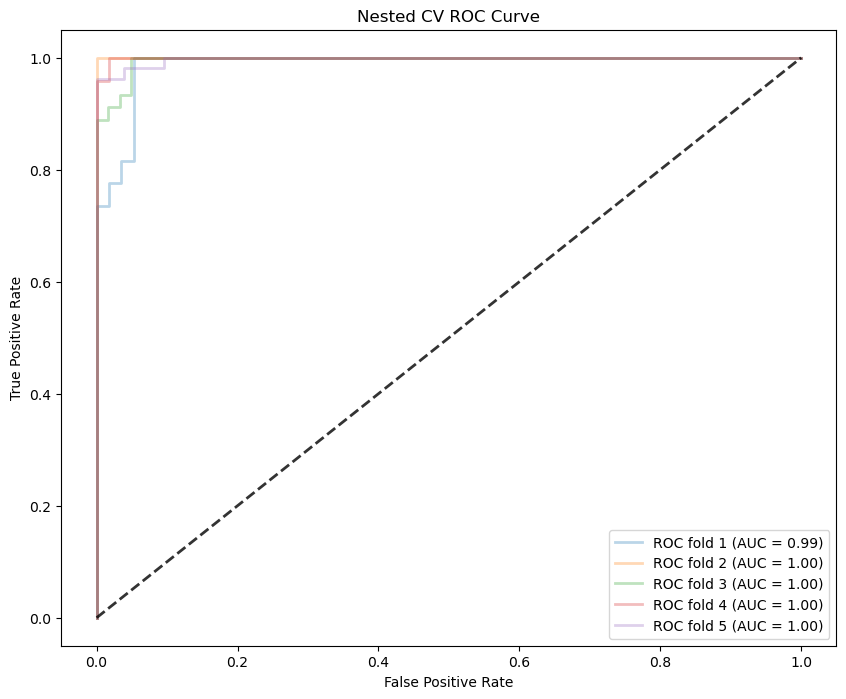

In [20]:
# Given the user's request, we will perform nested cross-validation and then plot the ROC curves
# for the best model found in the inner cross-validation on the test set.

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

# Define the outer cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

# We create a blank list to store ROC curve information for each outer fold
outer_fpr, outer_tpr, outer_roc_auc = [], [], []

# Loop through the splits of the outer cross-validation
for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    # The inner cross-validation
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # Define the model
    model = XGBClassifier(random_state=1)
    
    # Define the hyperparameter search space
    space = {
        'n_estimators': [10, 50, 100, 500],
        'max_depth': [6, 8, 10, 12, 20],
        'learning_rate': [0.001, 0.01, 0.1]
    }
    
    # Define the search
    search = GridSearchCV(model, space, scoring='roc_auc', cv=cv_inner, refit=True)
    
    # Execute search
    result = search.fit(X_train, y_train)
    
    # Get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    
    # Evaluate model on the test set
    y_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Store ROC AUC data
    outer_fpr.append(fpr)
    outer_tpr.append(tpr)
    outer_roc_auc.append(roc_auc)

# Now, plot the ROC curves
plt.figure(figsize=(10, 8))

# Plot each ROC curve
for i in range(cv_outer.n_splits):
    plt.plot(outer_fpr[i], outer_tpr[i], lw=2, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i+1, outer_roc_auc[i]))

# Plot the luck line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', alpha=.8)

# Axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Nested CV ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [40]:

# 0.728(0.065) -> MPR3

In [41]:
#Auc: 0.739(0.060)-> MPR2 

In [42]:
# Auc: 0.754(0.118)-> MPR1

In [127]:
(0.728 + 0.739 + 0.754) / 3

0.7403333333333334

In [ ]:
#Auc: 0.999 (0.001)-> MR1, amygdala, hippocampus 

In [ ]:
#Auc: 0.999(0.001)-> MR2 , amygdala, hippocampus

In [ ]:
#Auc: 0.980(0.040)-> MR3, amygdala, temporal 

In [ ]:
#Auc: Auc: 1.000(0.000)-> MR4, parietal inf_lav_vent 

In [272]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:58:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

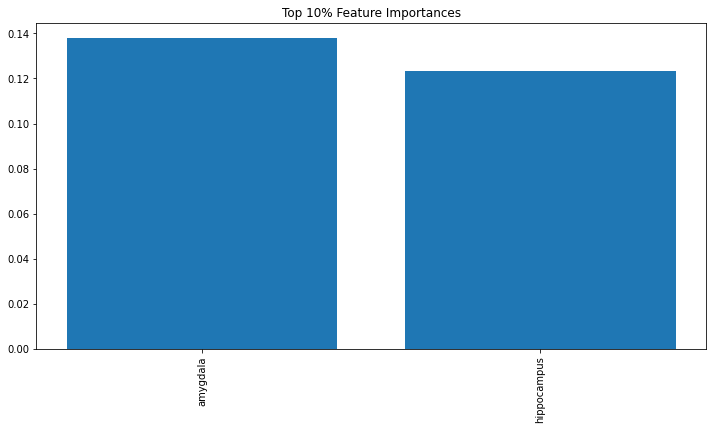

In [273]:
# Define the cross-validation procedures
cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

# Define the model and search space
model = XGBClassifier(random_state=1)
# define search space"
space = {'n_estimators' : [10, 50,100, 500],
        'max_features':['sqrt', 'log2'],
        'max_depth': [6, 8, 10, 12,20]}


# Initialize a list to store feature importances for each outer fold
feature_importances = []

# Loop over the folds defined by the outer cross-validation
for train_ix, test_ix in cv_outer.split(X):
    # Split data
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]

    # Define search
    search = GridSearchCV(model, space, scoring='roc_auc', n_jobs=1, cv=cv_inner, refit=True)
    
    # Fit the model
    search.fit(X_train, y_train)
    
    # Get the best model
    best_model = search.best_estimator_
    
    # Store feature importances
    feature_importances.append(best_model.feature_importances_)


# Compute average feature importance
average_importance = np.mean(feature_importances, axis=0)

# Sort features by importance
sorted_indices = np.argsort(average_importance)[::-1]

# Determine the number of top features to select (top 10%)
top_features_count = int(len(average_importance) * 0.1)

# Select the indices of the top 10% features
top_indices = sorted_indices[:top_features_count]

# Plot feature importances of the top 10%
plt.figure(figsize=(12, 6))
plt.title('Top 10% Feature Importances')
plt.bar(range(top_features_count), average_importance[top_indices], align='center')
plt.xticks(range(top_features_count), X.columns[top_indices], rotation=90)
plt.show()

In [17]:
# automatic nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, make_scorer

In [18]:
#random forest 

In [19]:
cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
# define the model
model2 = RandomForestClassifier(random_state=42)
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [2, 4, 6]
# define search
search = GridSearchCV(model2, space, scoring="roc_auc", n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, X, y, scoring ="roc_auc", cv=cv_outer, n_jobs=-1)
# report performance
print('Auc: %.3f (%.3f)' % (mean(scores), std(scores)))

Auc: 0.693 (0.068)


In [53]:
#MPR1Auc: 1.000 (0.000), amygdala, inf_lav_vent

In [54]:
#MPR2 AUC : Auc: 0.722 (0.080), inf_lav_vent

In [55]:
#MPR3 Auc: 0.693 (0.068), hippocampus, amygdala

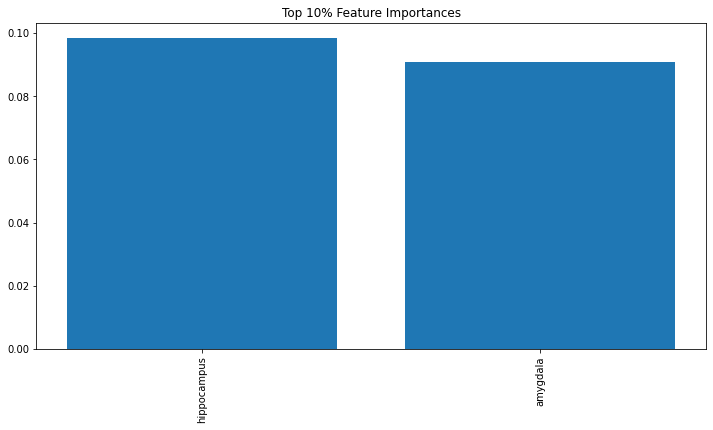

In [22]:
# Define the cross-validation procedures
cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

# Define the model and search space
model = RandomForestClassifier(random_state=1)
space = {
    'n_estimators': [10, 100, 500],
    'max_features': [2, 4, 6]
}

# Initialize a list to store feature importances for each outer fold
feature_importances = []

# Loop over the folds defined by the outer cross-validation
for train_ix, test_ix in cv_outer.split(X):
    # Split data
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]

    # Define search
    search = GridSearchCV(model, space, scoring='roc_auc', n_jobs=1, cv=cv_inner, refit=True)
    
    # Fit the model
    search.fit(X_train, y_train)
    
    # Get the best model
    best_model = search.best_estimator_
    
    # Store feature importances
    feature_importances.append(best_model.feature_importances_)


# Compute average feature importance
average_importance = np.mean(feature_importances, axis=0)

# Sort features by importance
sorted_indices = np.argsort(average_importance)[::-1]

# Determine the number of top features to select (top 10%)
top_features_count = int(len(average_importance) * 0.1)

# Select the indices of the top 10% features
top_indices = sorted_indices[:top_features_count]

# Plot feature importances of the top 10%
plt.figure(figsize=(12, 6))
plt.title('Top 10% Feature Importances')
plt.bar(range(top_features_count), average_importance[top_indices], align='center')
plt.xticks(range(top_features_count), X.columns[top_indices], rotation=90)
plt.show()

In [23]:
#XGBOOST 평균값

In [24]:
#

0.7403333333333334

In [25]:
# Random Forest 평균값

In [26]:
(1.0 + 0.722 + 0.693) / 3

0.805